# 目的
debertaでの学習を行う

In [1]:
# path setting
EXP_NAME = "e004-add-review-text-fold1"
MODEL_NAME = "microsoft/deberta-v3-xsmall"
COMPETITION_NAME = "atmacup17"

DATA_PATH = "data"
ENV_PATH = "env_file"
DATASET_NAME = f"{EXP_NAME}-{MODEL_NAME.split('/')[-1]}"
MODEL_OUTPUT_PATH = f"trained_models/{EXP_NAME}"
TARGET_COL = "Recommended IND"

# experiment parameter
DEBUG = False
TRAINING = True
UPLOAD_DATA_TO_S3 = True
# UPLOAD_DATA_TO_KAGGLE = True
WANDB = True

# model parameter
TRAINING_MAX_LENGTH = 512
INFERENCE_MAX_LENGTH = 512
SEED = 42
EPOCH = 4
LR = 2e-04
TRAIN_BS = 8
GRAD_ACC_STEP = 128 // TRAIN_BS  # 仮想的なバッチサイズはTRAIN_BS * GRAD_ACC_STEPとなる
EVAL_BS = 8
NUM_LABELS = 2

USE_FOLD = 1  # Fold数は3(0, 1, 2)

In [2]:
!nvidia-smi

In [3]:
!python --version

In [4]:
def resolve_path(base_path: str) -> str:
    import os

    cwd = os.getcwd()
    print(cwd)
    if cwd == f"/notebooks":
        print("Jupyter Kernel By VSCode!")
        return "kernel", f"/notebooks/{COMPETITION_NAME}/{base_path}"
    elif cwd == f"/notebooks/{COMPETITION_NAME}":
        print("nohup!")
        return base_path
    elif cwd == f"/notebooks/{COMPETITION_NAME}/{COMPETITION_NAME}/exp":
        print("Jupyter Lab!")
        return "nohup", f"../../{base_path}"
    elif cwd == f"/content":
        print("Google Colab!")
        return "colab", f"/content/drive/MyDrive/Kaggle/{COMPETITION_NAME}/{base_path}"
    elif cwd.startswith("/home/shinichiro.saito"):
        print("GCP!")
        return "GCP", f"/home/shinichiro.saito/{COMPETITION_NAME}/{base_path}"
    else:
        raise Exception("Unknown environment")


ENV_NAME, DATA_PATH = resolve_path(DATA_PATH)
print(DATA_PATH)
_, MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
print(MODEL_OUTPUT_PATH)
_, ENV_PATH = resolve_path(ENV_PATH)

In [5]:
def validate_dataset_name(dataset_name: str) -> None:
    if len(dataset_name) < 6 or len(dataset_name) > 50:
        raise Exception(
            f"データセットの文字列は6~50文字にしてください。現在{len(DATASET_NAME)}文字"
        )
    if "_" in dataset_name:
        raise Exception("datasetの名称に_の使用は禁止です")


validate_dataset_name(DATASET_NAME)

# install

In [6]:
if ENV_NAME != "GCP":
    %pip install -qq polars==1.0.0
    %pip install -qq transformers==4.42.3
    %pip install -qq sentencepiece==0.2.0
    %pip install -qq datasets==2.20.0
    %pip install -qq evaluate==0.4.2
    %pip install -qq seqeval==1.2.2
    %pip install -qq accelerate==0.32.0
    %pip install -qq python-dotenv==1.0.1
    %pip install -qq wandb==0.17.4
    %pip install -qq bitsandbytes==0.43.1
    %pip install -qq accelerate==0.32.0
    %pip install -qq peft==0.11.1

    # formatter
    %pip install -qq black isort

    %pip install -qq kaggle

# import

In [7]:
import os
import random
import ast
import json

import polars as pl
import numpy as np
import torch
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
import wandb
from datasets import (
    Dataset,
    DatasetDict,
    Value,
    concatenate_datasets,
    load_dataset,
    ClassLabel,
)
from sklearn.metrics import cohen_kappa_score
from tokenizers import AddedToken
from tqdm.auto import tqdm
from scipy.special import softmax
from sklearn.metrics import log_loss
from transformers import (
    AutoConfig,
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    DebertaV2PreTrainedModel,
    Trainer,
    TrainingArguments,
)
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.deberta_v2.modeling_deberta_v2 import (
    ContextPooler,
    StableDropout,
    DebertaV2Model,
)

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
NUM_PROC = os.cpu_count()
NUM_PROC

8

In [9]:
import transformers
import datasets
import evaluate

assert transformers.__version__ == "4.42.3"
assert datasets.__version__ == "2.20.0"
assert evaluate.__version__ == "0.4.2"

In [10]:
# Seed the same seed to all
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

In [11]:
from dotenv import load_dotenv

load_dotenv(f"{ENV_PATH}/.env")

True

# Wandb

In [12]:
if WANDB:
    wandb.login(key=os.environ["WANDB_API_KEY"])
    wandb.init(project=COMPETITION_NAME, name=EXP_NAME)
    REPORT_TO = "wandb"
else:
    REPORT_TO = "none"

REPORT_TO

'wandb'

# Data Import & Preprocess

In [13]:
with open(f"{DATA_PATH}/rec_stratified_fold.json") as f:
    label_stratified_fold = json.load(f)

In [14]:
train = (
    pl.read_csv(f"{DATA_PATH}/train_with_index.csv")
    .join(pl.read_csv(f"{DATA_PATH}/clothing_master.csv"), on="Clothing ID", how="left")
    .with_columns(
        pl.col("Title").fill_null(""),
        pl.col("Review Text").fill_null(""),
    )
    .rename({TARGET_COL: "label"})
    .with_columns(  # foldを追加する
        pl.col("index").replace(label_stratified_fold).alias("fold")
    )
)

test = (
    pl.read_csv(f"{DATA_PATH}/test_with_index.csv")
    .join(pl.read_csv(f"{DATA_PATH}/clothing_master.csv"), on="Clothing ID", how="left")
    .with_columns(
        pl.col("Title").fill_null(""),
        pl.col("Review Text").fill_null(""),
    )
)

In [15]:
if DEBUG:
    train = train.head(100)
    test = test.head(100)

In [16]:
train_dataset = Dataset.from_polars(train)
test_dataset = Dataset.from_polars(test)

In [17]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens([AddedToken("\n", normalized=False)])
tokenizer.add_tokens([AddedToken(" " * 2, normalized=False)])

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS
)
model.resize_token_embeddings(len(tokenizer))

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=16)

# Tokenize

In [18]:
train

index,Clothing ID,Age,Title,Review Text,Rating,label,Positive Feedback Count,Division Name,Department Name,Class Name,fold
i64,i64,i64,str,str,i64,i64,i64,str,str,str,i64
0,0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,"""General""","""Bottoms""","""Skirts""",2
1,0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,"""General""","""Bottoms""","""Skirts""",2
2,0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,"""General""","""Bottoms""","""Skirts""",1
3,0,45,"""""","""I was really pleased with this…",5,1,9,"""General""","""Bottoms""","""Skirts""",0
4,0,57,"""Unique, pretty asymmetric skir…","""I saw this skirt in retailer s…",5,1,1,"""General""","""Bottoms""","""Skirts""",1
…,…,…,…,…,…,…,…,…,…,…,…
9995,232,57,"""Runs big on top""","""""",3,1,5,"""General""","""Dresses""","""Dresses""",1
9996,232,58,"""""","""I loved the dress, but just no…",1,1,5,"""General""","""Dresses""","""Dresses""",0
9997,232,60,"""I was really disappointed""","""I was really hoping this dress…",2,0,7,"""General""","""Dresses""","""Dresses""",1


In [19]:
def tokenize(examples, max_token_length: int):
    separator = " [SEP] "

    joined_text = examples["Title"] + separator + examples["Review Text"]

    return tokenizer(
        joined_text,
        max_length=max_token_length,
        truncation=True,
        padding="max_length",
    )


# def tokenize(examples, max_token_length: int):
#     return tokenizer(
#         examples["Title"],
#         max_length=max_token_length,
#         truncation=True,
#         padding="max_length",
#     )


train_dataset = train_dataset.map(
    tokenize,
    batched=False,
    fn_kwargs={"max_token_length": TRAINING_MAX_LENGTH},
    num_proc=NUM_PROC,
)

test_dataset = test_dataset.map(
    tokenize,
    batched=False,
    fn_kwargs={"max_token_length": TRAINING_MAX_LENGTH},
    num_proc=NUM_PROC,
)

Map (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/11155 [00:00<?, ? examples/s]

In [20]:
tokenizer.decode(train_dataset[1]["input_ids"])

"[CLS] Very cute[SEP] Love the asymmetrical hem. waist fit snugly as in perfectly. it ties in two spots with a hidden zipper as well. a little stiff in the fabric. classic colors but decided not to keep only because i didn't feel like we could wear it all year round.   can't petite or 0p was great (115 lbs)[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][P

In [21]:
tokenizer.decode(test_dataset[1]["input_ids"])

"[CLS] Runs small[SEP] Beautiful patterns and colors, but it sits very high and runs small. i'm normally a size 4 and got the small. zipped all the way, but on the snug side. the skirt sits so high that the fabric coming down was a bit awkward. such a shame because it really is beautiful and looks great on the model probably because she's wearing a belt to hide how high it rides and flares out.[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PA

# Train Test Split

In [22]:
filtered_train = train_dataset.filter(
    lambda x: x["fold"] != USE_FOLD, num_proc=NUM_PROC
)
filtered_valid = train_dataset.filter(
    lambda x: x["fold"] == USE_FOLD, num_proc=NUM_PROC
)

train_valid_dataset = DatasetDict(
    {
        "train": filtered_train,
        "valid": filtered_valid,
    }
)

del filtered_train, filtered_valid

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

In [23]:
print(train_valid_dataset)

In [24]:
assert (
    set(train_valid_dataset["train"]["index"])
    & set(train_valid_dataset["valid"]["index"])
    == set()
)

In [25]:
from sklearn.metrics import roc_auc_score


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds_prob = softmax(predictions, axis=-1)
    return {"eval_roc_auc": roc_auc_score(labels, preds_prob[:, 1])}

In [26]:
# スケジューラの設定
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_PATH,
    learning_rate=LR,
    per_device_train_batch_size=TRAIN_BS,
    gradient_accumulation_steps=GRAD_ACC_STEP,
    eval_accumulation_steps=GRAD_ACC_STEP,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=EPOCH,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=0.1,
    save_strategy="steps",
    save_steps=0.1,
    save_total_limit=1,
    logging_steps=2,
    seed=SEED,
    metric_for_best_model="eval_roc_auc",
    greater_is_better=True,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine_with_restarts",
    report_to=REPORT_TO,
    run_name=EXP_NAME,
    load_best_model_at_end=True,
    fp16=True,
    fp16_full_eval=True,
    gradient_checkpointing=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_valid_dataset["train"],
    eval_dataset=train_valid_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [27]:
if TRAINING:
    # モデルの学習
    trainer.train()
    # ログの保存に利用したストレージを削除
    # os.system(f"rm -rf {MODEL_OUTPUT_PATH}/checkpoint-*")
    # モデルの保存
    trainer.save_model(MODEL_OUTPUT_PATH)
else:
    pass
# else:
#     # TRAINED_MODEL_PATHを用いて、学習済のモデルを読み込む
#     model = AutoModelForSequenceClassification.from_pretrained(
#         TRAINED_MODEL_PATH,
#         num_labels=NUM_LABELS,
#     )

#     args = TrainingArguments(
#         ".",
#         per_device_eval_batch_size=4,
#         report_to="none",
#         fp16=True,
#     )

#     trainer = Trainer(
#         model=model,
#         args=args,
#         data_collator=data_collator,
#         tokenizer=tokenizer,
#     )

Step,Training Loss,Validation Loss,Roc Auc
21,0.469600,0.347577,0.908576
42,0.252100,0.217323,0.951658
63,0.292000,0.257179,0.953411
84,0.211700,0.221744,0.954777
105,0.147200,0.241966,0.949184
126,0.210300,0.228003,0.957921
147,0.105300,0.247153,0.956724
168,0.078900,0.250012,0.956713
189,0.116300,0.261564,0.953927


# valid_datasetの作成・保存

In [28]:
from sklearn.metrics import roc_auc_score


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds_prob = softmax(predictions, axis=-1)
    return {"eval_roc_auc": roc_auc_score(labels, preds_prob[:, 1])}

In [29]:
# TRAININGをINFERRENCEでMAX_TOKENを変えるために、validを作り直す
valid_dataset = train_dataset.filter(
    lambda example: example["index"] in train_valid_dataset["valid"]["index"],
    num_proc=NUM_PROC,
)

valid_dataset = valid_dataset.map(
    tokenize,
    batched=False,
    fn_kwargs={"max_token_length": INFERENCE_MAX_LENGTH},
    num_proc=NUM_PROC,
)


def add_valid_pred(example, idx, valid_pred):
    example["valid_pred"] = valid_pred[idx]
    return example


valid_pred = softmax(trainer.predict(valid_dataset).predictions, axis=-1)

np.save(f"{MODEL_OUTPUT_PATH}/valid_prediction.npy", valid_pred)

valid_dataset = valid_dataset.map(
    add_valid_pred, with_indices=True, fn_kwargs={"valid_pred": valid_pred[:, 1]}
)

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/3333 [00:00<?, ? examples/s]

Map:   0%|          | 0/3333 [00:00<?, ? examples/s]

In [30]:
(
    valid_dataset.to_polars()
    .select(pl.exclude("input_ids", "attention_mask", "token_type_ids"))
    .write_csv(f"{MODEL_OUTPUT_PATH}/valid_dataset_{EXP_NAME}.csv")
)

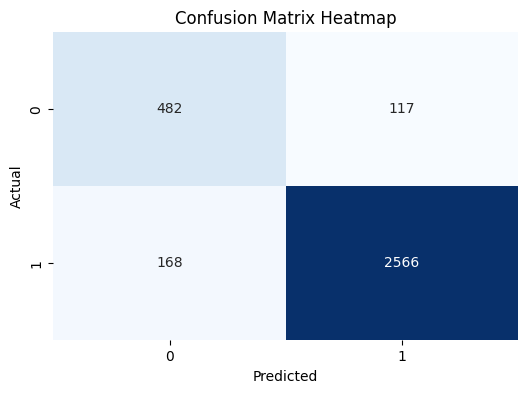

In [31]:
# 混同行列の作成
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 混同行列を作成
cm = confusion_matrix(valid_dataset["label"], valid_pred.argmax(axis=1))

# Seabornでヒートマップをプロット
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=[0, 1],
    yticklabels=[0, 1],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.savefig(f"{MODEL_OUTPUT_PATH}/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# CVの計算

In [32]:
from sklearn.metrics import accuracy_score

accuracy_score(valid_dataset["label"], valid_pred.argmax(axis=1))

0.9144914491449145

In [33]:
cv_score = roc_auc_score(valid_dataset["label"], valid_pred[:, 1])
print(f"CV Score: {cv_score}")

In [34]:
# output_textを保存
with open(f"{MODEL_OUTPUT_PATH}/cv_score.txt", "w") as f:
    f.write(str(cv_score))

# テストに対する計算

In [35]:
test_dataset = test_dataset.map(
    tokenize,
    batched=False,
    fn_kwargs={"max_token_length": INFERENCE_MAX_LENGTH},
    num_proc=NUM_PROC,
)


def add_valid_pred(example, idx, valid_pred):
    example["valid_pred"] = valid_pred[idx]
    return example


test_pred = softmax(trainer.predict(test_dataset).predictions, axis=-1)

Map (num_proc=8):   0%|          | 0/11155 [00:00<?, ? examples/s]

# 提出ファイルの作成

In [36]:
sample_submission = pl.read_csv(f"{DATA_PATH}/sample_submission.csv")

if DEBUG:
    sample_submission = sample_submission.head(100)

(
    sample_submission.with_columns(
        pl.Series(test_pred[:, 1]).alias("target")
    ).write_csv(f"{MODEL_OUTPUT_PATH}/submission_{EXP_NAME}_cv{cv_score:.4f}.csv")
)

# AWSへのアップロード

In [37]:
# S3へのアップロード
# if not DEBUG and UPLOAD_DATA_TO_S3:
if UPLOAD_DATA_TO_S3:
    # uninstall
    !sudo rm /usr/bin/aws
    !sudo rm /usr/bin/aws_completer
    !sudo rm -rf /usr/local/aws-cli

    # install
    !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    !unzip -o -qq awscliv2.zip
    !sudo ./aws/install --update

    # upload
    output_name = MODEL_OUTPUT_PATH.split("/")[-1]
    os.system(
        f"aws s3 cp --recursive {MODEL_OUTPUT_PATH} s3://{COMPETITION_NAME}/trained_model/{output_name}"
    )

In [38]:
# ダウンロード（参考）
# !sudo rm /usr/bin/aws
# !sudo rm /usr/bin/aws_completer
# !sudo rm -rf /usr/local/aws-cli

# !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
# !unzip -o -qq awscliv2.zip
# !sudo ./aws/install --update

# !aws s3 cp --recursive s3://automated-essay-scoring/trained_model/e005-regression /notebooks/automated_essay_scoring/trained_models/e005-regression

In [39]:
if WANDB:
    wandb.finish()

In [40]:
print("finish Notebook!")